In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import utility_functions as uf
import dft_model as dft

%matplotlib inline

In [2]:
input_file = '../sms-tools/sounds/bendir.wav'
!play '../sms-tools/sounds/bendir.wav'


../sms-tools/sounds/bendir.wav:

 File Size: 278k      Bit Rate: 706k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 44100Hz      
Replaygain: off         
  Duration: 00:00:03.15  

In:100%  00:00:03.15 [00:00:00.00] Out:139k  [      |      ]        Clip:0    
Done.


In [3]:
window = 'hamming'
# window size
m = 2001 
# FFT size
n = 2048
# Magnitude threshold of spectral peaks
t = -80
# Min duration required for sinusoid detection
min_sine_duration = 0.02
# Max number of sine waves to be detected
max_n_sines = 150
# Amount of deviation allowed in sinusoid from frame to frame at freq = 0
freq_dev_offset = 10
# slope of freq deviation (needed to adjust for the fact that higher freqs tend to have higher deviation)
freq_dev_slope = 0.001

In [4]:
# Size of FFT to be used in the synthesis
n_s = 512
# Hop size (n_s / 4)
h = n_s / 4
fs, x = uf.wavread(input_file)

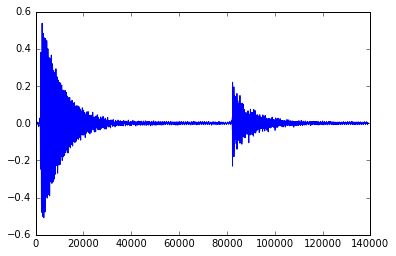

In [5]:
plt.plot(x);

In [6]:
w = get_window(window, m)

# Begin the Sinusoidal Model Analysis

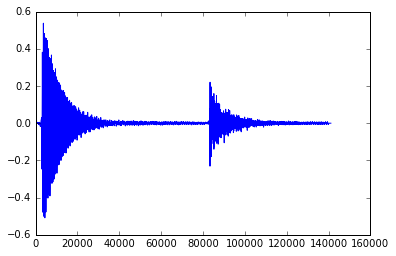

In [7]:
# sine_model_analysis(x, fs, w, n, h, t, max_n_sines, min_sine_duration, freq_dev_offset, freq_dev_slope)
hM1 = int(np.floor((w.size + 1) / 2))
hM2 = int(np.floor(w.size / 2))
x = np.append(np.zeros(hM2), x)
x = np.append(x,np.zeros(hM2))
plt.plot(x)

In [8]:
# initialize sound pointer at middle of window
pin = hM1 
pend = x.size - hM1
# normalize window
w = w / sum(w) 

# Sinusoid Tracking
### Brief Explanation before Diving into the Analysis

For each sample, sinusoid tracking is done to determine if a detected sinusoid perpetuates from one frame to the next. The following functions does this, and some explanation follows.

In [9]:
def sine_tracking(
    p_freq, p_mag, p_phase, t_freq, freq_dev_offset = 20, freq_dev_slope = 0.01):
    '''
    Tracking sinusoids from one frame to the next                           
    p_freq, p_mag, p_phase: frequencies and magnitude of current frame         
    t_freq: frequencies of incoming tracks from previous frame               
    freq_dev_offset: minimum frequency deviation at 0Hz                       
    freq_dev_slope: slope increase of minimum frequency deviation             
    
    returns t_freq_n, t_mag_n, t_phase_n: frequency, magnitude and phase of       
    tracks                                                                  
    '''

    t_freq_n  = np.zeros(t_freq.size)
    t_mag_n   = np.zeros(t_freq.size)
    t_phase_n = np.zeros(t_freq.size)

    # indices of current peaks
    p_indices = np.array(np.nonzero(p_freq), dtype = np.int)[0]
    # indices of incoming tracks (for all samples except the first)
    incoming_tracks = np.array(np.nonzero(t_freq), dtype = np.int)[0]
    new_tracks = np.zeros(t_freq.size, dtype = np.int) - 1 # initialize to -1
    # order current peaks by magnitude
    mag_order = np.argsort(-p_mag[p_indices])
    # copy current peaks, mags, and phases to temp arrays
    p_freq_t  = np.copy(p_freq)
    p_mag_t   = np.copy(p_mag)
    p_phase_t = np.copy(p_phase)

    # continue incoming tracks
    if incoming_tracks.size > 0: 
        # iterate over current peaks
        for i in mag_order:
            # break if no more incoming tracks
            if incoming_tracks.size == 0:
                break
            # closest incoming track to peak
            track = np.argmin(abs(p_freq_t[i] - t_freq[incoming_tracks]))
            freq_distance = abs(p_freq[i] - t_freq[incoming_tracks[track]])

            # if distance is within threshold
            if freq_distance < (freq_dev_offset + freq_dev_slope * p_freq[i]):
                # assign peak index to track index
                new_tracks[incoming_tracks[track]] = i 
                # delete index of track in incoming tracks 
                incoming_tracks = np.delete(incoming_tracks, track)

    index_t = np.array(np.nonzero(new_tracks != -1), dtype = np.int)[0]

    if index_t.size > 0:
        index_p = new_tracks[index_t]           # inds of assigned peaks
        t_freq_n[index_t]  = p_freq_t[index_p]  # output freq...
        t_mag_n[index_t]   = p_mag_t[index_p]   # ...mag
        t_phase_n[index_t] = p_phase_t[index_p] # ...and phase tracks
        
        p_freq_t  = np.delete(p_freq_t,  index_p) # delete used peaks
        p_mag_t   = np.delete(p_mag_t,   index_p) # ...
        p_phase_t = np.delete(p_phase_t, index_p) # ...
        
    # Create new tracks from unused peaks
    # index of empty incoming tracks
    empty_t = np.array(np.nonzero(t_freq == 0), dtype = np.int)[0]
    # sort remaining peaks by mag
    peaks_left = np.argsort(-p_mag_t)
    
    if ((peaks_left.size > 0) and (empty_t.size >= peaks_left.size)):
        # Fill empty tracks
        t_freq_n[empty_t[:peaks_left.size]]  = p_freq_t[peaks_left]
        t_mag_n[empty_t[:peaks_left.size]]   = p_mag_t[peaks_left]
        t_phase_n[empty_t[:peaks_left.size]] = p_phase_t[peaks_left]
    elif ((peaks_left.size > 0) and (empty_t.size < peaks_left.size)):
        t_freq_n[empty_t] = p_freq_t[peaks_left[:empty_t.size]]
        t_mag_n[empty_t] = p_mag_t[peaks_left[:empty_t.size]]
        t_phase_n[empty_t] = p_phase_t[peaks_left[:empty_t.size]]
        t_freq_n = np.append(t_freq_n, p_freq_t[peaks_left[empty_t.size:]])
        t_mag_n = np.append(t_mag_n, p_mag_t[peaks_left[empty_t.size:]])
        t_phase_n = np.append(t_phase_n, p_phase_t[peaks_left[empty_t.size:]])
    
    return t_freq_n, t_mag_n, t_phase_n

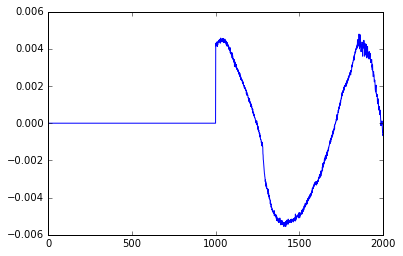

In [10]:
t_freq = np.array([])

# Run sine tracking on just the first sample:
# select initial frame
x1 = x[pin - hM1:pin + hM2]
plt.plot(x1)

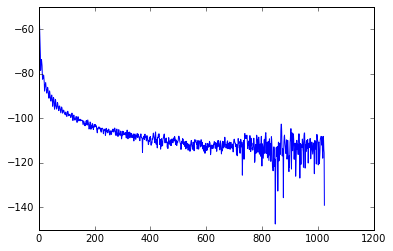

In [11]:
# Compute DFT
mX, pX = dft.dft_analysis(x1, w, n)  
plt.plot(mX)

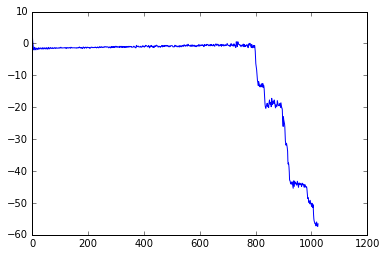

In [12]:
plt.plot(pX)

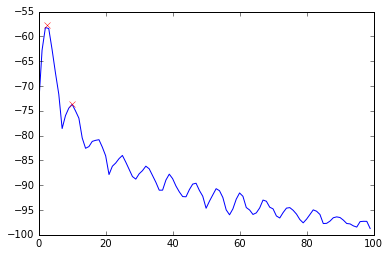

In [13]:
# Detect peak locations
p_loc = uf.peakDetection(mX, t)
# Refine ploc values by interpolation
ip_loc, ip_mag, ip_phase = uf.peakInterp(mX, pX, p_loc)
# Convert peak locations to Hz
ip_freq = fs * ip_loc / float(n)

# Zoom in on magnitude spectrom and indicate peaks detected
plt.plot(mX[:100])

plt.plot(ip_loc, ip_mag, 'rx')

In [14]:
# Sine-Tracking
t_freq, t_mag, t_phase = sine_tracking(
    ip_freq, ip_mag, ip_phase, t_freq, freq_dev_offset, freq_dev_slope)

In [15]:
t_freq

array([  52.8647402 ,  212.34552284])

In [16]:
t_mag

array([-57.7042627 , -73.68101135])

In [17]:
t_phase

array([-0.32591257, -1.43844106])

The same procedure will be run for all frames in the sample, but first a helper function to help clean the tracks.

In [49]:
def clean_sine_tracks(t_freq, min_track_length = 3):
    '''
    Delete short fragments of a collection of sinusoidal tracks             
    t_freq: frequency of tracks                                              
    min_track_length: minimum duration of tracks in number of frames          
    
    returns t_freq_n: output frequency of tracks                              
    '''
    
    if t_freq.shape[1] == 0:
        return t_freq
    
    n_frames = t_freq[:, 0].size                                                
    n_tracks = t_freq[0, :].size # number of tracks in a frame                                                                  
    
    # iterate over all tracks
    for t in range(n_tracks): 
        track_freqs = t_freq[:, t] # frequencies of one track      
        # begining of track contours                                                             
        track_begs = np.nonzero((track_freqs[:n_frames - 1] <= 0) & 
                                (track_freqs[1:] > 0))[0] + 1
        if track_freqs[0] > 0:
            track_begs = np.insert(track_begs, 0, 0)

        # end of track contours                                                                  
        track_ends = np.nonzero((track_freqs[:n_frames - 1] > 0) &
                                (track_freqs[1:] <= 0))[0] + 1
        if track_freqs[n_frames - 1] > 0:
            track_ends = np.append(track_ends, n_frames - 1)
        
        # lengths of trach contours                                                              
        track_lengths = 1 + track_ends - track_begs

        for i, j in zip(track_begs, track_lengths):              
            # delete short track contours                                                            
            if j <= min_track_length:
                track_freqs[i:i + j] = 0
        
    return t_freq

In [53]:
# Do the same for all samples, and further process

# re-initialize
x = np.append(np.zeros(hM2), x)
x = np.append(x, np.zeros(hM2))
pin = hM1 
pend = x.size - hM1
t_freq = np.array([]) 

while pin < pend:
    x1 = x[pin - hM1:pin + hM2]
    mX, pX = dft.dft_analysis(x1, w, n)  
    p_loc = uf.peakDetection(mX, t)
    ip_loc, ip_mag, ip_phase = uf.peakInterp(mX, pX, p_loc)
    ip_freq = fs * ip_loc / float(n)
    
    # Sine-Tracking
    t_freq, t_mag, t_phase = sine_tracking(
        ip_freq, ip_mag, ip_phase, t_freq, freq_dev_offset, freq_dev_slope)

    # limit no. of tracks to max_n_sines
    t_freq  = np.resize(t_freq,  min(max_n_sines, t_freq.size))
    t_mag   = np.resize(t_mag,   min(max_n_sines, t_mag.size))
    t_phase = np.resize(t_phase, min(max_n_sines, t_phase.size))
    
    # Temp output arrays:
    jt_freq  = np.zeros(max_n_sines)
    jt_mag   = np.zeros(max_n_sines)
    jt_phase = np.zeros(max_n_sines)
    
    # Save tracks to temp arrays:
    jt_freq[:t_freq.size]   = t_freq 
    jt_mag[:t_mag.size]     = t_mag
    jt_phase[:t_phase.size] = t_phase
    
    # if first frame, init output sine tracks
    if pin == hM1: 
        xt_freq  = jt_freq
        xt_mag   = jt_mag
        xt_phase = jt_phase
    else:
        xt_freq  = np.vstack((xt_freq,  jt_freq))
        xt_mag   = np.vstack((xt_mag,   jt_mag))
        xt_phase = np.vstack((xt_phase, jt_phase))
    # hop to next frame
    pin += h 
    
# delete sine tracks shorter than minSineDur                            
xt_freq = clean_sine_tracks(xt_freq, round(fs * min_sine_duration / h))

# return xtfreq, xtmag, xtphase

In [54]:
t_freq  = xt_freq
t_mag   = xt_mag
t_phase = xt_phase

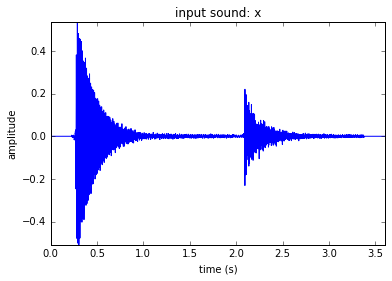

In [55]:
max_plot_freq = 5000.0

# plots
plt.plot(np.arange(x.size) / float(fs), x)
plt.axis([0, x.size / float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (s)')
plt.title('input sound: x')

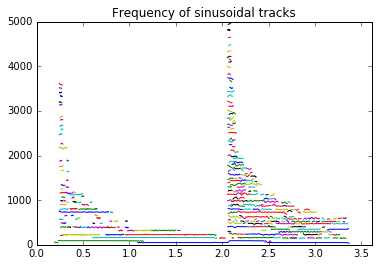

In [56]:
# Plot sinusoidal freqs
num_frames = t_freq.shape[0]
frm_time = h * np.arange(num_frames) / float(fs)
t_freq[t_freq <= 0] = np.nan
plt.plot(frm_time, t_freq)
plt.axis([0, x.size / float(fs), 0, max_plot_freq])
plt.title('Frequency of sinusoidal tracks')

# Synthesis